## Experimental Design

+ A process
+ An objective and controlled way to draw specific conclusions in reference to a hypothesis

## Forming robust statements

Lacking precision: *X probably had an effect on Y. There is likely some small risk of error*

+ Precise and Quantified language
  + More precise: *P-value analysis indicates X had an effect on Y with a 10% risk of Type I error (Type I error: incorrectly reject null hypothesis)*
+ Goal: Experimental design and statistical analysis

## Non-random assignment of subjects

***Scenario***: An agricultural firm is conducting an experiment to measure how feeding sheep different types of grass affects their weight. They have asked for your help to properly set up the experiment. One of their managers has said you can perform the subject assignment by taking the top 250 rows from the DataFrame and that should be fine.

We can clearly demonstrate why this might not be a good idea. Assign the subjects to two groups using non-random assignment (the first 250 rows) and observe the differences in descriptive statistics.

In [1]:
import numpy as np
import pandas as pd

def read_fixed_width(data_file_name, data_dir="./data/", drop_row_col="row"):
    data_file_path = data_dir + data_file_name
    df = pd.read_fwf(data_file_path)
    if drop_row_col is not None:
        df.drop(drop_row_col, axis="columns", inplace=True)

    return df

weights = read_fixed_width('weights.txt')
weights.head()

,id,weight
0,262,39.07
1,74,44.04
2,471,46.58
3,382,48.01
4,442,48.46


In [2]:
# Non-random assignment
group1_non_rand = weights.iloc[:250,]
group2_non_rand = weights.iloc[250:,]

# compare descriptive statistics of groups
compare_df_non_rand = pd.concat([group1_non_rand['weight'].describe(), group2_non_rand['weight'].describe()], axis=1)
compare_df_non_rand.columns = ['group1', 'group2']

# Print to assess
print(compare_df_non_rand)

           group1      group2
count  250.000000  250.000000
mean    58.821560   71.287480
std      4.503791    5.019958
min     39.070000   65.100000
25%     56.200000   67.490000
50%     59.390000   70.115000
75%     62.527500   73.770000
max     65.100000   95.820000


In [3]:
# Randomly assign half
group1_random = weights.sample(n=250, random_state=42, replace=False)

# Create second assignment
group2_random = weights.drop(group1_random.index)

# Compare assignments
compare_df_random = pd.concat([group1_random['weight'].describe(), group2_random['weight'].describe()], axis=1)
compare_df_random.columns = ['group1', 'group2']
print(compare_df_random)

           group1      group2
count  250.000000  250.000000
mean    64.499960   65.609080
std      8.073025    7.596346
min     39.070000   44.040000
25%     58.660000   60.312500
50%     64.620000   65.540000
75%     69.957500   70.442500
max     86.760000   95.820000


## Experimental data setup

Dataset for the e-commerce example (`econ`) in video 2 is not provided.

### Blocking on productivity

Randomly create 2 equal-sized blocks of 50 each

### Stratifying an experiment

***Scenario:*** You are working with a government organization that wants to undertake an experiment around how some particular government policies impact the net wealth of individuals in a number of areas.

They have approached you to help set up the experimental design. They have warned you that there is likely to be a small group of users who already have high net wealth and are concerned that this group might overshadow any experimental outcome observed. We know just what to do!

In [4]:
productivity_subjects = pd.read_csv('./data/productivity_subjects.csv', index_col='index')
productivity_subjects.head()

,subject_id
index,
0,1
1,2
2,3
3,4
4,5


In [5]:
# Randomly assign half
block_1 = productivity_subjects.sample(n=50, random_state=42, replace=False)

# Set the block column
block_1['block'] = 1

# Create second assignment and label
block_2 = productivity_subjects.drop(block_1.index)
block_2['block'] = 2

# Concatenate and print
productivity_combined = pd.concat([block_1, block_2], axis=0)
print(productivity_combined['block'].value_counts())

block
1    50
2    50
Name: count, dtype: int64


In [6]:
wealth_data = read_fixed_width('wealth_data.txt')
wealth_data.head()

,net_wealth,service_involvement,high_wealth
0,112820.451,19,0
1,106850.675,19,0
2,118590.331,19,0
3,184323.773,12,0
4,166439.516,10,0


In [7]:
# Create the first block
strata_1 = wealth_data[wealth_data['high_wealth'] == 1].copy()
strata_1['Block'] = 1

# Create two groups assigning to Treatment or Control
strata_1_g1 = strata_1.sample(n=100, replace=False)  # could use frac=0.5 instead of n=100
strata_1_g1['T_C'] = 'T' 
strata_1_g2 = strata_1.drop(strata_1_g1.index)
strata_1_g2['T_C'] = 'C'

# Create the second block and assign groups
strata_2 = wealth_data[wealth_data['high_wealth'] == 0].copy()
strata_2['Block'] = 2

strata_2_g1 = strata_2.sample(n=900, replace=False)  # could use frac=0.5 instead of n=900
strata_2_g1['T_C'] = 'T'
strata_2_g2 = strata_2.drop(strata_2_g1.index)
strata_2_g2['T_C'] = 'C'

# Concatenate the grouping work
wealth_data_stratified = pd.concat([strata_1_g1, strata_1_g2, strata_2_g1, strata_2_g2])
print(wealth_data_stratified.groupby(['Block','T_C', 'high_wealth']).size())

Block  T_C  high_wealth
1      C    1              100
       T    1              100
2      C    0              900
       T    0              900
dtype: int64


## Visualizing normality in an agricultural experiment

***Scenario:*** We have been contracted by an agricultural firm conducting an experiment on 50 chickens, divided into four groups, each fed a different diet. Weight measurements were taken every second day for 20 days.

We'll analyze chicken_data to assess normality, which will determine the suitability of parametric statistical tests, beginning with a visual examination of the data distribution. 

In [8]:
chicken_data = pd.read_csv('./data/chick_weight.csv')
chicken_data.head()

,weight,Time,Chick,Diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1


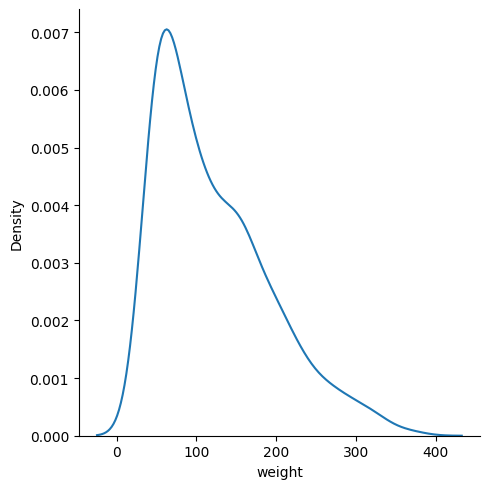

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the chickens' weight
sns.displot(data=chicken_data, x='weight', kind="kde")
plt.show()

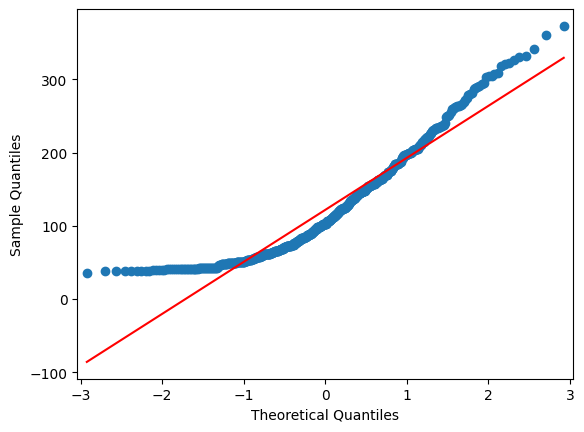

In [10]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm
# Plot the qq plot of the chickens' weight
qqplot(data=chicken_data['weight'], line='s')
plt.show()  # bow-shaped tails, not very normal looking

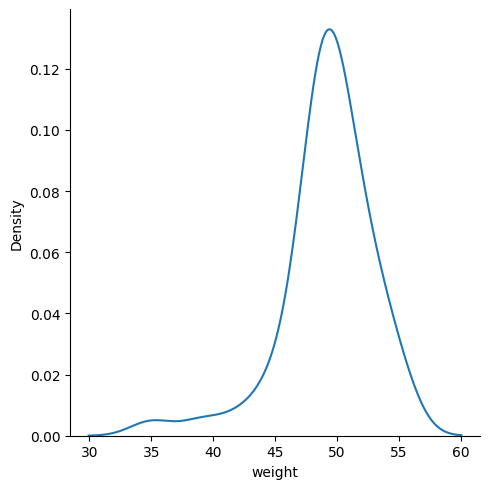

In [11]:
# Subset the data and plot the weight of the subset
subset_data = chicken_data[chicken_data['Time'] == 2]

sns.displot(data=subset_data, x='weight', kind="kde")
plt.show()  # much more normal looking

## Analytical normality in an agricultural experiment

Continuing from the previous work, visual inspections of the data indicate it may not be a normal dataset overall, but that the initial time point may be.

Here, we'll use analytical methods to determine the normality of the dataset.

In [12]:
from scipy.stats import shapiro
from scipy.stats import anderson

# Shapiro-Wilk normality test on the weight column
test_statistic, p_value = shapiro(chicken_data['weight'])

print(f"p: {round(p_value, 4)} test stat: {round(test_statistic, 4)}")

p: 0.0 test stat: 0.9087


At significance level $\alpha = 0.05$, we reject the $H_0$ (likely normal) in favor of the altenative (not normal)

In [13]:
# Anderson-Darling test
result = anderson(chicken_data['weight'], dist="norm")

print(f"Test statistic: {round(result.statistic, 4)}")
print(f"Significance Levels: {result.significance_level}")
print(f"Critical Values: {result.critical_values}")

Test statistic: 14.6868
Significance Levels: [15.  10.   5.   2.5  1. ]
Critical Values: [0.572 0.652 0.782 0.912 1.085]


Since `14.6868` > `0.782`, reject $H_0$ (normal) in favor of altenative (not normal) at 5% significance level

## Understanding marketing campaign effectiveness

***Scenario:*** You're a digital marketer analyzing data from a recent campaign to understand what messaging style and time of day yield the highest conversions. This analysis is crucial for guiding future marketing strategies, ensuring that the messages reach potential customers when they're most likely to engage. Here, we'll work with a dataset giving the outcomes of different messaging styles ('Casual' versus 'Formal') and times of day ('Morning' versus 'Evening') on conversion rates, a common scenario in marketing data analysis.

In [14]:
marketing_data = pd.read_feather('./data/marketing_data.feather')
print(marketing_data.shape)
marketing_data.head()

(950, 4)


,Messaging_Style,Time_of_Day,Click_Through_Rate,Conversions
0,Casual,Morning,0.640465,500
1,Formal,Evening,0.698533,598
2,Casual,Morning,0.257834,234
3,Casual,Evening,0.922971,602
4,Casual,Morning,0.476893,314


In [15]:
# pivot table for marketing campaign data
marketing_pivot = marketing_data.pivot_table(
  values='Conversions', 
  index='Messaging_Style', 
  columns='Time_of_Day', 
  aggfunc='mean')

# pivoted results
print(marketing_pivot)

Time_of_Day         Evening     Morning
Messaging_Style                        
Casual           402.329004  401.133891
Formal           432.913043  411.096000


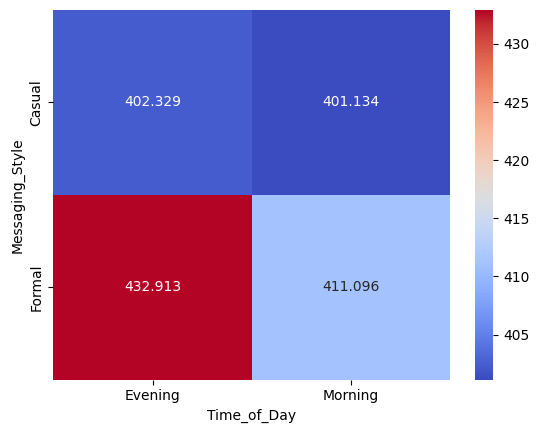

In [16]:
# visualize interactions with a heatmap
sns.heatmap(marketing_pivot, 
            annot=True, 
            cmap='coolwarm',
            fmt='g')

plt.show()

## Implementing a randomized block design

***Scenario:*** A manufacturing firm is interested in conducting some experiments on worker productivity. Previously, the two blocks were set randomly. While this can work, it can be better to group subjects based on similar characteristics.

The DataFrame called `productivity` has 1300 subjects. It includes a worker `productivity_score` column based on units produced per hour. This column was binned into three groups to generate blocks based on similar productivity values. The firm would like to apply a new incentive program with three options (`Bonus`, `Profit Sharing` and `Work from Home`) throughout the firm with treatment applied randomly.

In [17]:
productivity = read_fixed_width('productivity_subjects2.txt')
print(productivity.info())
productivity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          1300 non-null   int64  
 1   productivity_score  1300 non-null   float64
 2   block               1299 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 30.6 KB
None


,subject_id,productivity_score,block
0,1,11.9,2.0
1,2,28.6,3.0
2,3,22.2,3.0
3,4,18.4,2.0
4,5,5.5,1.0


In [18]:
# randomly assign workers to blocks
# observed=False : show all values for categorical groupers
prod_df = productivity.groupby('block', observed=False)[productivity.columns].apply(
    lambda x: x.sample(frac=1)
)

# Reset the index
prod_df = prod_df.reset_index(drop=True)

# Assign treatment randomly
prod_df['Treatment'] = np.random.choice(
  ['Bonus', 'Profit Sharing', 'Work from Home'],
  size=len(prod_df)
)

prod_df.head()

,subject_id,productivity_score,block,Treatment
0,209,1.1,1.0,Bonus
1,16,6.3,1.0,Profit Sharing
2,875,1.7,1.0,Work from Home
3,20,9.4,1.0,Bonus
4,1145,8.7,1.0,Work from Home


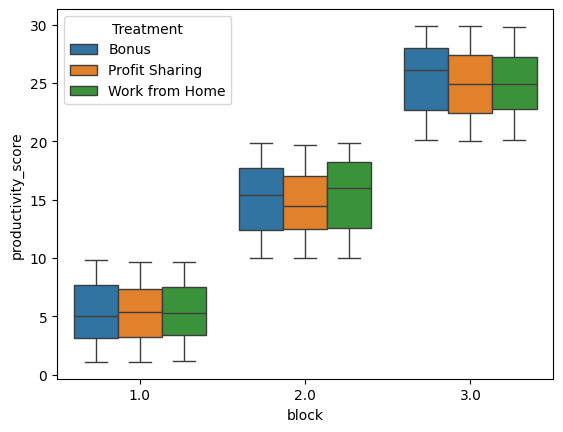

In [19]:
# visualize how positivity_score varies within blocks
sns.boxplot(x='block', 
            y='productivity_score', 
            hue='Treatment', 
            data=prod_df)

plt.show()

## ANOVA within blocks of employees

Building on the previous analyses with the manufacturing firm, where worker productivity was examined across different blocks and an incentive program was introduced, we'll now delving deeper into the data. The firm, equipped with a more comprehensive dataset in the productivity DataFrame, including 1200 additional employees and their productivity_score, has structured the workforce into three blocks based on productivity levels. Each employee has been randomly assigned one of three incentive options: `Bonus`, `Profit Sharing`, or `Work from Home`.

Before assessing the full impact of these incentive treatments on productivity, it's crucial to verify that the initial treatment assignment was indeed random and equitable across the different productivity blocks. This step ensures that any observed differences in productivity post-treatment can be confidently attributed to the incentive programs themselves, rather than **pre-existing disparities** in the blocks.

In [20]:
from scipy.stats import f_oneway

# Perform the within blocks ANOVA, first grouping by block
within_block_anova = prod_df.groupby('block')[prod_df.columns].apply(
  # Set function
  lambda x: f_oneway(
    # Filter Treatment values based on outcome
    x[x['Treatment'] == 'Bonus']['productivity_score'], 
    x[x['Treatment'] == 'Profit Sharing']['productivity_score'],
    x[x['Treatment'] == 'Work from Home']['productivity_score'])
)
# print(type(within_block_anova), within_block_anova.index, type(within_block_anova.index))
# print(within_block_anova)
print(f"block 1: f_stat = {within_block_anova[1][0]}, p_value = {within_block_anova[1][1]}")
print(f"block 1: f_stat = {within_block_anova[2][0]}, p_value = {within_block_anova[2][1]}")
print(f"block 1: f_stat = {within_block_anova[3][0]}, p_value = {within_block_anova[3][1]}")

block 1: f_stat = 0.051380304908359216, p_value = 0.9499234145767195
block 1: f_stat = 2.5849074897324726, p_value = 0.0765556783431987
block 1: f_stat = 0.40573425101300054, p_value = 0.6667363601330009


At an $\alpha = 0.05$, only `block` = 1 provide evidence that all 3 treatments are **not** the same.

## Covariate adjustment in experimental design with chick growth

***Scenario:*** We are studying the growth patterns of chicks under various dietary regimens. The data from this study sheds light on the intricate relationship between their respective diets and the consequent impact on their weight. This data includes weight measurements of chicks at different ages, allowing for an exploration of covariate adjustment. `age` serves as a covariate, potentially influencing the outcome variable: the `weight` of the chicks.



In [21]:
exp_chick_data = read_fixed_width('exp_chick_data.txt')

print(exp_chick_data.shape, '\n')
print(exp_chick_data.head(15), '\n')
cov_chick_data = pd.read_fwf('./data/cov_chick_data.txt')
cov_chick_data.drop('idx', axis="columns", inplace=True)
print(cov_chick_data.shape, '\n')
print(cov_chick_data.head(15), '\n')

(578, 3) 

    Chick  Diet  weight
0       1     1      42
1       1     1      51
2       1     1      59
3       1     1      64
4       1     1      76
5       1     1      93
6       1     1     106
7       1     1     125
8       1     1     149
9       1     1     171
10      1     1     199
11      1     1     205
12      2     1      40
13      2     1      49
14      2     1      58 

(578, 2) 

    Chick  Time
0       1     0
1       1     2
2       1     4
3       1     6
4       1     8
5       1    10
6       1    12
7       1    14
8       1    16
9       1    18
10      1    20
11      1    21
12      2     0
13      2     2
14      2     4 



In [22]:
# Join experimental and covariate data
merged_chick_data = pd.merge(exp_chick_data, 
                             cov_chick_data, left_index=True, right_index=True)
merged_chick_data.drop('Chick_y', axis="columns", inplace=True)
merged_chick_data.rename(columns={"Chick_x": "Chick"}, inplace=True)
# Print the merged data
print(merged_chick_data)

     Chick  Diet  weight  Time
0        1     1      42     0
1        1     1      51     2
2        1     1      59     4
3        1     1      64     6
4        1     1      76     8
..     ...   ...     ...   ...
573     50     4     175    14
574     50     4     205    16
575     50     4     234    18
576     50     4     264    20
577     50     4     264    21

[578 rows x 4 columns]


                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     809.2
Date:                Fri, 20 Jun 2025   Prob (F-statistic):          6.77e-168
Time:                        20:33:50   Log-Likelihood:                -2897.1
No. Observations:                 578   AIC:                             5800.
Df Residuals:                     575   BIC:                             5813.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5428      4.043      0.382      0.7

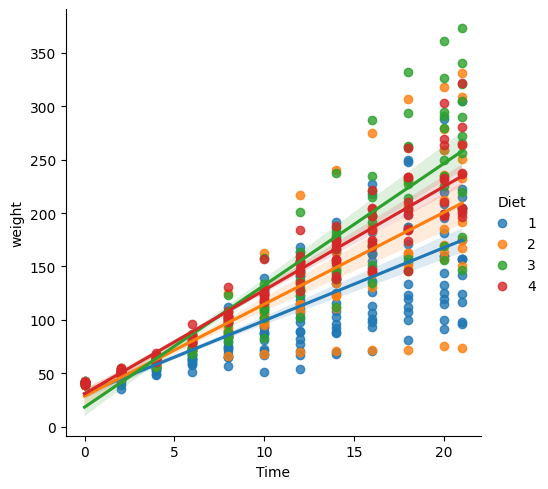

In [23]:
from statsmodels.formula.api import ols

# ANCOVA with Diet and Time as predictors
model = ols('weight ~ Diet + Time', data=merged_chick_data).fit()

# Print a summary of the model
print(model.summary())

# Visualize Diet effects with Time adjustment
sns.lmplot(x='Time', y='weight', 
           hue='Diet', 
           data=merged_chick_data)
plt.show()

## Choosing the right statistical test

We'll focus on:  t-tests, ANOVA, and chi-square

In [24]:
athletic_perf_entire = pd.read_csv('./data/athletic_perf.csv')
print(athletic_perf_entire.shape)
athletic_perf_entire.head()

(300, 5)


,Athlete_ID,Training_Program,Diet_Type,Initial_Fitness,Performance_Inc
0,1,Strength,Keto,Low,8.749524
1,2,HIIT,Plant-Based,High,9.452781
2,3,Strength,Plant-Based,Low,13.928506
3,4,Strength,Plant-Based,High,9.605557
4,5,HIIT,Plant-Based,Low,7.547894


In [25]:
sample_example = [167, 289, 164, 30, 186]
bool_mask = athletic_perf_entire['Athlete_ID'].isin(sample_example)
athletic_perf_sample = athletic_perf_entire.loc[bool_mask, :]
athletic_perf_sample

,Athlete_ID,Training_Program,Diet_Type,Initial_Fitness,Performance_Inc
29,30,Strength,Keto,Medium,7.384686
163,164,Endurance,Plant-Based,Medium,11.614835
166,167,Endurance,Plant-Based,High,9.113040
185,186,HIIT,High-Protein,Low,6.776078
288,289,Endurance,Keto,Low,11.039744


### Independent samples t-test
+ Comparing means of two groups
+ **Assumptions:** normal distribution, equal variances
+ Insufficient evidence of a difference in means at 5% significance

In [26]:
from scipy.stats import ttest_ind
# group1 = athletic_perf_sample[athletic_perf_sample['Training_Program'] == 'HIIT']['Performance_Inc']
# group2 = athletic_perf_sample[athletic_perf_sample['Training_Program'] == 'Endurance']['Performance_Inc']

group1 = athletic_perf_entire[athletic_perf_entire['Training_Program'] == 'HIIT']['Performance_Inc']
group2 = athletic_perf_entire[athletic_perf_entire['Training_Program'] == 'Endurance']['Performance_Inc']

t_stat, p_val = ttest_ind(group1, group2)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 0.20671020082912311, P-value: 0.8364563849070619


### One-way ANOVA
+ Comparing means across multiple (>2) groups
+ **Assumption:** equal variances among groups
+ Insufficient evidence of a difference in means at 5% significance

In [27]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(athletic_perf_entire.loc[athletic_perf_entire['Training_Program'] == 'HIIT', 'Performance_Inc'],
                         athletic_perf_entire.loc[athletic_perf_entire['Training_Program'] == 'Endurance', 'Performance_Inc'],
                         athletic_perf_entire.loc[athletic_perf_entire['Training_Program'] == 'Strength', 'Performance_Inc'])

print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 1.5270022393256704, P-value: 0.21888590090505408


## Chi-square test of association
+ Testing relationships between categorical variables
+ No assumptions about distributions
+ Insufficient evidence of an association at 5% (alpha) significance

In [28]:
from scipy.stats import chi2_contingency 

contingency_table = pd.crosstab(athletic_perf_entire['Training_Program'], 
                                athletic_perf_entire['Diet_Type'])
contingency_table

Diet_Type,High-Protein,Keto,Plant-Based
Training_Program,,,
Endurance,33,28,33
HIIT,27,32,40
Strength,38,29,40


In [29]:
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table) 
print(f"Chi2-statistic: {chi2_stat}, P-value: {p_val}") 

Chi2-statistic: 2.154450885821988, P-value: 0.7073764021451128


## Choosing the right test: petrochemicals

In a chemistry research lab, scientists are examining the efficiency of three well-known catalysts—Palladium (Pd), Platinum (Pt), and Nickel (Ni)—in facilitating a particular reaction. Each catalyst is used in a set of identical reactions under controlled conditions, and the time taken for each reaction to reach completion is meticulously recorded. Your goal is to compare the mean reaction times across the three catalyst groups to identify which catalyst, if any, has a significantly different reaction time.

In [30]:
chemical_reactions = pd.read_csv('./data/chemical_reactions.csv')
chemical_reactions.head()

,Catalyst,Reaction_Time
0,Palladium,47.483571
1,Palladium,44.308678
2,Palladium,48.238443
3,Palladium,52.615149
4,Palladium,43.829233


In [31]:
catalyst_types = ['Palladium', 'Platinum', 'Nickel']

# Collect reaction times for each catalyst into a list
groups = [chemical_reactions[chemical_reactions['Catalyst'] == catalyst]['Reaction_Time'] for catalyst in catalyst_types]

# Perform the one-way ANOVA across the three groups
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 478.7412625615453, P-value: 4.710677600047866e-151


### Choosing the right test: human resources

In human resources, it's essential to understand the relationships between different variables that might influence employee satisfaction or turnover. Consider a scenario where an HR department is interested in understanding the association between the department in which employees work and their participation in a new workplace wellness program. The HR team has compiled this data over the past two years and has asked you if there's any significant association between an employee's department and their enrolling in the wellness program.

In [32]:
hr_wellness = pd.read_csv('./data/hr_wellness.csv')
print(hr_wellness.columns)
print(hr_wellness['Department'].unique())
hr_wellness.head()

Index(['Department', 'Wellness_Program_Status'], dtype='object')
['Marketing' 'Sales' 'Engineering']


,Department,Wellness_Program_Status
0,Marketing,Enrolled
1,Sales,Enrolled
2,Marketing,Not Enrolled
3,Marketing,Not Enrolled
4,Sales,Enrolled


In [33]:
# create contingency table
contingency_table = pd.crosstab(
  hr_wellness['Department'], 
  hr_wellness['Wellness_Program_Status']
)

# perform chi-square test of association
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2-statistic: {chi2_stat}, P-value: {p_val}")

Chi2-statistic: 3.4775739037369617, P-value: 0.17573344450112738


There's no significant association between department and enrollment in the wellness program, as the P-value is larger than `0.05`.

## Choosing the right test: finance

In the realm of finance, investment strategists are continually evaluating different approaches to maximize returns. Consider a scenario where a financial firm wishes to assess the effectiveness of two investment strategies: "Quantitative Analysis" and "Fundamental Analysis". The firm has applied each strategy to a separate set of investment portfolios for a year and now asks you to compare the annual returns to determine if there is any difference in strategy returns by comparing the mean returns of the two groups.

This is job for the ***independent t-test***.

In [34]:
investment_returns = pd.read_csv('./data/investment_returns.csv')
print(investment_returns.columns)
# print(investment_returns['Strategy_Type'].unique())  # ['Quantitative' 'Fundamental']
investment_returns.head()

Index(['Strategy_Type', 'Annual_Return'], dtype='object')


,Strategy_Type,Annual_Return
0,Quantitative,10.597379
1,Quantitative,1.656248
2,Quantitative,9.202100
3,Quantitative,3.980213
4,Quantitative,8.086720


In [35]:
from scipy.stats import ttest_ind

# Separate the annual returns by strategy type
quantitative_returns = investment_returns[investment_returns['Strategy_Type'] == 'Quantitative']['Annual_Return']
fundamental_returns = investment_returns[investment_returns['Strategy_Type'] == 'Fundamental']['Annual_Return']

# independent samples t-test between the two groups
t_stat, p_val = ttest_ind(quantitative_returns, fundamental_returns)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 7.784788496693728, P-value: 2.0567003424807143e-14


## Post-hoc analysis following ANOVA

+ Tukey's HSD (Honest Significant Difference)
  + Robust for multiple comparisons
  + Best for broader comparisons
+ Bonferroni Correction
  + Adjusts p-values to control for Type I errors
  + Best for focused tests

## Anxiety treatments ANOVA

***Senario:*** Psychologists conducted a study to compare the effectiveness of three types of therapy on reducing anxiety levels: Cognitive Behavioral Therapy (CBT), Dialectical Behavior Therapy (DBT), and Acceptance and Commitment Therapy (ACT). Participants were randomly assigned to one of the three therapy groups, and their anxiety levels were measured before and after the therapy sessions. The psychologists have asked you to determine if there are any significant differences in the effectiveness of these therapies.

In [36]:
therapy_outcomes = read_fixed_width('therapy_outcomes.txt')

therapy_outcomes.head()

,Therapy_Type,Anxiety_Reduction
0,ACT,17.484
1,DBT,14.309
2,ACT,18.238
3,CBT,22.615
4,DBT,13.829


In [37]:
# Pivot to view the mean anxiety reduction for each therapy
pivot_table = therapy_outcomes.pivot_table(
    values='Anxiety_Reduction', 
    index='Therapy_Type', 
    aggfunc="mean")
print(pivot_table)

              Anxiety_Reduction
Therapy_Type                   
ACT                   14.929203
CBT                   14.962154
DBT                   15.729271


### Are the difference between the mean shown above significant?

+ Test with ANOVA
+ Test with Tukey's HSD test

In [38]:
# Create groups to prepare the data for ANOVA
therapy_types = ['CBT', 'DBT', 'ACT']
groups = [therapy_outcomes[therapy_outcomes['Therapy_Type'] == ttype]['Anxiety_Reduction']
          for ttype in therapy_types]
# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

0.019577165206377665


### Tukey's HSD test

For the ***ANOVA***, since `0.0196` < `alpha = 0.05`, we reject the null hypothesis that all means are the same. However, we don't know which difference pair is significant. The ***Tukey's HSD test*** will shine some light on this question.

In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    therapy_outcomes["Anxiety_Reduction"], 
    therapy_outcomes["Therapy_Type"],
    alpha=0.05
)

print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   ACT    CBT    0.033 0.9941 -0.7136 0.7795  False
   ACT    DBT   0.8001 0.0358  0.0418 1.5583   True
   CBT    DBT   0.7671 0.0433  0.0181 1.5161   True
---------------------------------------------------


## Applying Bonferoni correction

After identifying significant differences between therapy groups with Tukey's HSD, let's see if we can confirm our findings with the ***Bonferroni correction***. The Bonferroni correction is a conservative statistical adjustment used to counteract the problem of multiple comparisons. It reduces the chance of obtaining false-positive results by adjusting the significance level. In the context of our study on the effectiveness of CBT, DBT, and ACT, applying the Bonferroni correction will help ensure that the significant differences we observe between therapy groups are not due to chance.

In [40]:
from scipy.stats import ttest_ind 
from statsmodels.sandbox.stats.multicomp import multipletests

p_values = []

therapy_pairs = [('CBT', 'DBT'), ('CBT', 'ACT'), ('DBT', 'ACT')]

# Conduct t-tests and collect P-values
for pair in therapy_pairs:
    group1 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[0]]['Anxiety_Reduction']
    group2 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[1]]['Anxiety_Reduction']
    t_stat, p_val = ttest_ind(group1, group2)
    p_values.append(p_val)

# Apply Bonferroni correction
print(multipletests(p_values, alpha=0.05, method='bonferroni')[1])

[0.04519159 1.         0.04606889]


Here, we again see that **ACT and CBT** (the middle of the three pairs) don't differ significantly from this experiment due to the corrected P-value of 1. This makes sense intuitively given that:

ACT mean = 14.929203  
CBT mean = 14.962154

## P-values, alpha, and errors

+ **P-values:** probability of observing our data if the null hypothesis was true
+ α: threshold at which we consider our results *statistically significant*
+ P-value ≤ α: Reject null in favor of alternative hypothesis

## More on alpha
+ Common values: 0.05, 0.01, and 0.10
  + Reflecting a 5%, 1%, and 10% probability of making a Type I error
+ Choosing an α
  + Based on the context of the study
  + Balancing a tolerance for Type I (rejecting $H_0$ when it is true) and Type II (failing to reject $H_0$ when it is false) errors
+ Conventions:
  + 0.05 (5%): Most common, used as a convention
  + 0.01 (1%): More stringest testing, where **cost of Type I error is high**
  + 0.10 (10%): Sometimes in preliminary studies, where **higher tolerance for Type I error**

## Analyzing toy durability

***Scenario:*** In product development within the toy industry, it's crucial to understand the durability of toys, particularly when comparing educational toys to recreational ones. Durability can significantly impact customer satisfaction and repeat business. Researchers in a toy manufacturing company have asked you to conduct the analysis of a study comparing the durability of educational toys versus recreational toys. The `toy_durability` DataFrame contains the results of these tests, with durability scores assigned based on rigorous testing protocols.

In [41]:
toy_durability = read_fixed_width('toy_durability.txt')

toy_durability.head()

,Toy_Type,Durability_Score
0,Recreational,67.2
1,Recreational,80.9
2,Recreational,69.7
3,Recreational,82.7
4,Educational,79.6


In [42]:
# Calculate mean Durability_Score for each Toy_Type
mean_durability = toy_durability.pivot_table(
  values='Durability_Score', index='Toy_Type', aggfunc="mean")
print(mean_durability)

# Perform t-test
educational_durability = toy_durability[toy_durability['Toy_Type'] == 'Educational']['Durability_Score']
recreational_durability = toy_durability[toy_durability['Toy_Type'] == 'Recreational']['Durability_Score']
t_stat, p_val = ttest_ind(educational_durability, recreational_durability)

print(p_val)

              Durability_Score
Toy_Type                      
Educational          80.100737
Recreational         79.460632
0.020313353856485136


## Visualizing durability differences

Following the analysis of toy durability, the research team is interested in visualizing the distribution of durability scores for both Educational and Recreational toys. Such visualizations can offer intuitive insights into the data, potentially highlighting the range and variability of scores within each category.

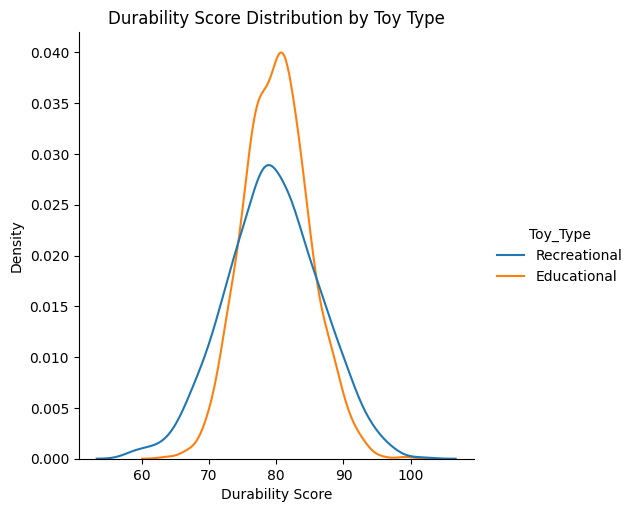

In [43]:
# Visualize the distribution of Durability_Score for each Toy_Type
sns.displot(data=toy_durability, x="Durability_Score", 
         hue="Toy_Type", kind="kde")
plt.title('Durability Score Distribution by Toy Type')
plt.xlabel('Durability Score')
plt.ylabel('Density')
plt.show()

## Power analysis: sample and effect size

+ **Effect size**: Quantifies the difference between two groups
+ **Cohen's d**: Standard measure for effect size. See function below.
  + uses *pooled standard variance*: $\sigma_p = \sqrt{ \dfrac{(n_1 - 1)\times\text{var}_1 + (n_2 -1)\times\text{var}_2}{n_1 + n_2 -2} }$
+ **Power**: the probability of correctly rejecting a false null hypothesis: $(1 − \beta)$
  + $\beta$: probability of not rejecting null hypothesis when it is false (Type II error)
  + Ranges between 0 and 1 (certainty in ability to detect a true effect)
+ To compute **Power**, must specify an **effect size** first


In [44]:
def cohens_d(group1, group2):
    """ Computes Cohen's d as an effect size in comparing
    two groups.

    Args:
      group1 - pandas series of the first group
      group2 - pandas series of the second group

    Returns:
      float64 value for Cohen's d
    
    """
    diff = group1.mean() - group2.mean() 
    n1, n2 = len(group1), len(group2) 
    var1, var2 = group1.var(), group2.var() 
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)) 
    d = diff / pooled_std 
    return d

In [45]:
from statsmodels.stats.power import TTestIndPower

# Instantiate a TTestIndPower object
power_analysis = TTestIndPower()

# Conduct a power analysis to determine the required sample size
required_n = power_analysis.solve_power(
    effect_size=0.5, 
    alpha=0.05, 
    power=0.9, 
    ratio=1)

print(required_n)

85.03128688801546


## Synthesizing insights from complex experiments

### Visualizing loan approval yield

In financial services, understanding the factors that influence loan approval rates is crucial for both lenders and borrowers. A financial institution has conducted a study and collected data on loan applications, detailing the amount requested, the applicant's credit score, employment status, and the ultimate yield of the approval process. This rich dataset offers a window into the nuanced dynamics at play in loan decision-making. We'll dive into a `loan_approval_yield` dataset to understand how loan amounts and credit scores influence approval yields.

In [46]:
loan_approval_yield = pd.read_csv('./data/loan_approval_yield.csv',
                                  usecols=['ApplicationID', 'LoanAmount', 'CreditScore',
                                           'EmploymentStatus', 'ApprovalYield'])
loan_approval_yield.head()

,ApplicationID,LoanAmount,CreditScore,EmploymentStatus,ApprovalYield
0,1,High,Excellent,Unemployed,0.183435
1,2,Low,Poor,Self-Employed,0.445833
2,3,High,Good,Self-Employed,0.866176
3,4,High,Fair,Unemployed,0.969910
4,5,Medium,Fair,Employed,0.181825


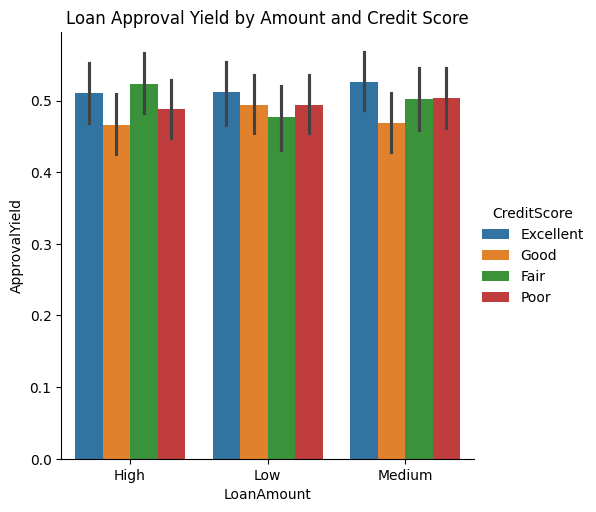

In [47]:
# visualize
sns.catplot(x="LoanAmount", 
            y="ApprovalYield", 
            hue="CreditScore",
            hue_order=["Excellent", "Good", "Fair", "Poor"],
            kind="bar", 
            data=loan_approval_yield)
plt.title("Loan Approval Yield by Amount and Credit Score")
plt.show()

### What does the analysis of approval yields across different credit scores and loan amounts reveal?

The data shows that `Poor` credit scores tend to have similar approval yields across various loan amounts, while Good credit scores exhibit more variability, reflecting different lending criteria based on the loan size.

In [48]:
customer_satisfaction = pd.read_csv('./data/customer_satisfaction.csv')
customer_satisfaction.drop('Unnamed: 0', axis='columns', inplace=True)
customer_satisfaction.head()

,ApplicationID,ResponseTime,InterestRate,CustomerInteraction,SatisfactionQuality
0,1,Fast,Low,Poor,0.204979
1,2,Moderate,High,Good,0.462610
2,3,Slow,Medium,Average,0.874398
3,4,Moderate,High,Average,0.428884
4,5,Fast,High,Poor,0.126637


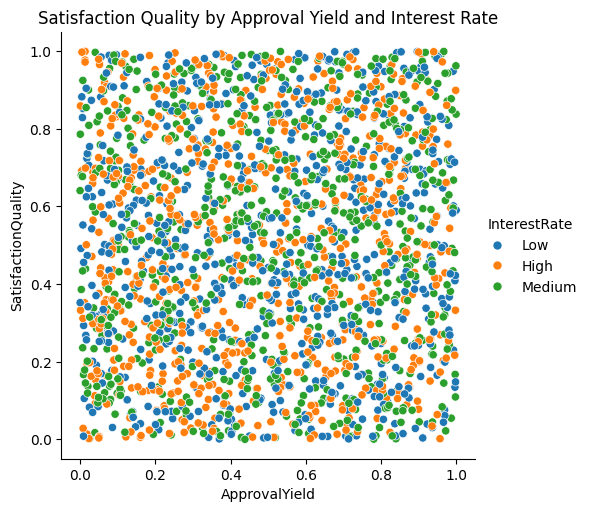

In [49]:
# merge the two datasets
merged_data = pd.merge(loan_approval_yield, 
                       customer_satisfaction, 
                       on='ApplicationID')
# visualize with scatter plot
sns.relplot(x="ApprovalYield", 
            y="SatisfactionQuality", 
            hue="InterestRate", 
            kind="scatter", 
            data=merged_data)
plt.title("Satisfaction Quality by Approval Yield and Interest Rate")
plt.show()

There isn't a strong relationship between Customer Satisfaction and Approval Yield in this experimental data. The resulting scatterplot looks similar to white noise scattered all about even when including Interest Rate.

## Addressing complexities in experimental data

+ interactions
+ confounding
+ heteroscedasticity

### Check for heteroscedasticity in shelf life

When examining food preservation methods, it's crucial to understand how the variance of one variable, such as shelf life, might change across the range of another variable like nutrient retention. Identifying such patterns, known as **heteroscedasticity**, can provide insights into the consistency of preservation effects. The food_preservation dataset encapsulates the outcomes of various preservation methods on different food types, specifically highlighting the balance between nutrient retention and resultant shelf life.

In [50]:
food_preservation = read_fixed_width('food_preservation.txt')
food_preservation.head()

,ProductID,PreservationMethod,FoodType,NutrientRetention,ShelfLife
0,1,Drying,Fruit,59.17,184.04
1,2,Freezing,Meat,72.29,104.46
2,3,Drying,Fruit,80.06,75.03
3,4,Canning,Fruit,98.50,103.34
4,5,Canning,Vegetable,59.09,97.46


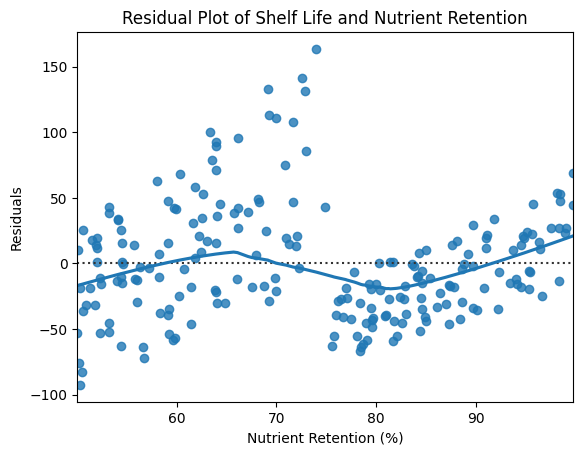

In [51]:
# Check for heteroscedasticity with a residual plot
sns.residplot(x='NutrientRetention', y='ShelfLife', 
         data=food_preservation, lowess=True)
plt.title('Residual Plot of Shelf Life and Nutrient Retention')
plt.xlabel('Nutrient Retention (%)')
plt.ylabel('Residuals')
plt.show()

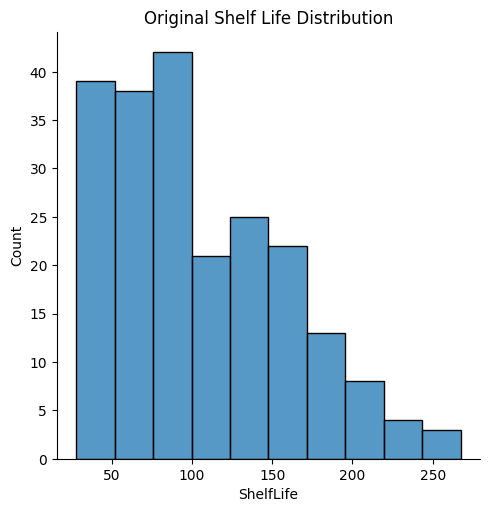

In [52]:
# visualize original ShelfLife distribution
sns.displot(food_preservation['ShelfLife'])
plt.title('Original Shelf Life Distribution')
plt.show()

<Figure size 640x480 with 0 Axes>

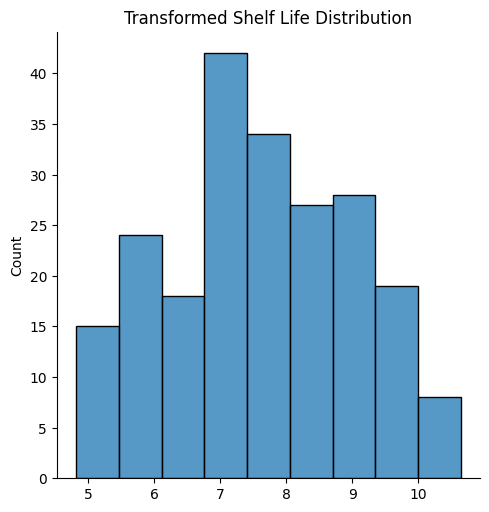

In [53]:
from scipy.stats import boxcox
# Create a Box-Cox transformation
ShelfLifeTransformed, _ = boxcox(food_preservation['ShelfLife'])

# Visualize the transformed ShelfLife distribution
plt.clf()
sns.displot(ShelfLifeTransformed)
plt.title('Transformed Shelf Life Distribution')
plt.show()

## Applying nonparametric tests in experimental analysis

### Visualizing and testing preservation methods

***Scenario:*** As a food scientist, we're tasked with evaluating the effectiveness of different preservation methods on nutrient retention and how these methods impact shelf life. We have been provided with a dataset, `food_preservation`, that includes various types of food preserved by methods such as freezing and canning. Each entry in the dataset captures the nutrient retention and calculated shelf life for these foods, providing a unique opportunity to analyze the impacts of preservation techniques on food quality.

PreservationMethod
Drying      75
Freezing    74
Canning     66
Name: count, dtype: int64


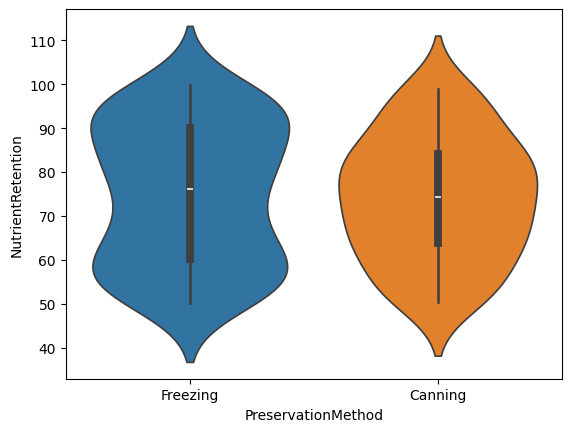

In [54]:
from scipy.stats import mannwhitneyu

print(food_preservation['PreservationMethod'].value_counts())
# Filter to Freezing and Canning data
condensed_food_data = food_preservation[food_preservation['PreservationMethod'].isin(['Freezing', 'Canning'])]

# Create a violin plot for nutrient retention by preservation method
sns.violinplot(data=condensed_food_data, 
     x="PreservationMethod", 
     y="NutrientRetention",
     hue="PreservationMethod")
plt.show()

In [55]:
# Separate nutrient retention for Freezing and Canning methods
freezing = food_preservation[food_preservation['PreservationMethod'] == 'Freezing']['NutrientRetention']
canning = food_preservation[food_preservation['PreservationMethod'] == 'Canning']['NutrientRetention']

# Perform Mann Whitney U test
u_stat, p_val = mannwhitneyu(
    freezing, canning
)

# Print the p-value
print("Mann Whitney U test p-value:", p_val)

Mann Whitney U test p-value: 0.7211582066472636


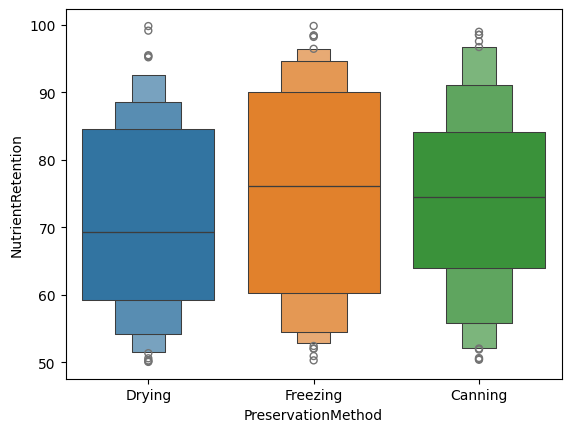

In [56]:
# Create a boxen plot for nutrient retention by preservation
sns.boxenplot(data=food_preservation, 
     x="PreservationMethod", 
     y="NutrientRetention",
     hue="PreservationMethod")
plt.show()

In [57]:
from scipy.stats import kruskal

# Separate nutrient retention for each preservation method
freezing = food_preservation[food_preservation['PreservationMethod'] == 'Freezing']['NutrientRetention']
canning = food_preservation[food_preservation['PreservationMethod'] == 'Canning']['NutrientRetention']
drying = food_preservation[food_preservation['PreservationMethod'] == 'Drying']['NutrientRetention']

# Perform Kruskal-Wallis test
k_stat, k_pval = kruskal(freezing, canning, drying)
print("Kruskal-Wallis test p-value:", k_pval)

Kruskal-Wallis test p-value: 0.38534203658094596
